In [1]:
import folium
from folium import plugins

In [8]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv
import torch
import geopandas as gpd
from shapely.geometry import Point
from shapely.wkt import loads

In [5]:
import scipy


In [3]:
df = pd.read_csv('/scratch/umni5/a/shives/Knowledge_graph/Data/chicago_one_week.csv')

In [4]:
df

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Percent Time Chicago,Percent Distance Chicago,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,...,Trip Total,Shared Trip Authorized,Shared Trip Match,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,fd456782b7a1d422008bf6c99a449862695608f0,08/18/2024 11:45:00 PM,08/19/2024 12:00:00 AM,777,6.0,1.0,1.0,1.703106e+10,1.703184e+10,6.0,...,19.85,False,False,1,41.942692,-87.651771,POINT (-87.6517705068 41.9426918444),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707)
1,ffea1345c24005b42c6e7f85879f78b826f8331f,08/18/2024 11:45:00 PM,08/19/2024 12:00:00 AM,715,4.0,1.0,1.0,NaN,NaN,24.0,...,14.28,False,False,1,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2,ffbed9214da69cac25a9b44c897528592797a501,08/18/2024 11:45:00 PM,08/19/2024 12:00:00 AM,703,5.4,1.0,1.0,NaN,NaN,24.0,...,14.51,False,False,1,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.938666,-87.711211,POINT (-87.7112105933 41.9386661962)
3,ff7fba15bb6c31a2fbd3497cc79644dbfc357508,08/18/2024 11:45:00 PM,08/18/2024 11:45:00 PM,325,1.2,1.0,1.0,1.703108e+10,1.703108e+10,8.0,...,10.62,False,False,1,41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809)
4,ff653aa9fdcebe35c1ebdfd7408b5a66d923201a,08/18/2024 11:45:00 PM,08/19/2024 12:15:00 AM,1856,23.2,1.0,1.0,1.703198e+10,NaN,76.0,...,52.97,False,False,1,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707167,17f6595376fd7033e55133d4785a38ee2f411ff7,08/12/2024 12:00:00 AM,08/12/2024 12:15:00 AM,1008,6.2,1.0,1.0,NaN,NaN,66.0,...,16.12,False,False,1,41.771849,-87.695666,POINT (-87.695666342 41.7718485152),41.839087,-87.714004,POINT (-87.714003807 41.8390869059)
1707168,181f15757d4603b5e74e94b202e770f019e65d18,08/12/2024 12:00:00 AM,08/12/2024 12:15:00 AM,768,4.7,1.0,1.0,1.703106e+10,1.703132e+10,6.0,...,19.13,False,False,1,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
1707169,183727b124c4fa1810e76ece2aa1c22ea8ddd8ad,08/12/2024 12:00:00 AM,08/12/2024 12:30:00 AM,2424,26.2,1.0,1.0,NaN,NaN,NaN,...,33.73,False,False,1,NaN,NaN,NaN,41.890609,-87.756047,POINT (-87.7560467111 41.8906088526)
1707170,184ac7baab67ccc5071de53caca8bd307a342e76,08/12/2024 12:00:00 AM,08/12/2024 12:15:00 AM,515,2.5,1.0,1.0,NaN,NaN,5.0,...,10.19,False,False,1,41.947792,-87.683835,POINT (-87.6838349425 41.9477915865),41.968069,-87.721559,POINT (-87.7215590627 41.968069)


In [6]:
df.columns.tolist()

['Trip ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Percent Time Chicago',
 'Percent Distance Chicago',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Pickup Community Area',
 'Dropoff Community Area',
 'Fare',
 'Tip',
 'Additional Charges',
 'Trip Total',
 'Shared Trip Authorized',
 'Shared Trip Match',
 'Trips Pooled',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Pickup Centroid Location',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid Location']

In [7]:
df = df.dropna(subset=['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 
                       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude'])


In [8]:
df['trip_start'] = pd.to_datetime(df['Trip Start Timestamp'],errors='coerce')
df['trip_end'] = pd.to_datetime(df['Trip End Timestamp'],errors='coerce')


/tmp/ipykernel_1217986/1254573091.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trip_start'] = pd.to_datetime(df['Trip Start Timestamp'],errors='coerce')
/tmp/ipykernel_1217986/1254573091.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trip_end'] = pd.to_datetime(df['Trip End Timestamp'],errors='coerce')


In [9]:
df

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Percent Time Chicago,Percent Distance Chicago,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,...,Shared Trip Match,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,trip_start,trip_end
0,fd456782b7a1d422008bf6c99a449862695608f0,08/18/2024 11:45:00 PM,08/19/2024 12:00:00 AM,777,6.0,1.0,1.0,1.703106e+10,1.703184e+10,6.0,...,False,1,41.942692,-87.651771,POINT (-87.6517705068 41.9426918444),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),2024-08-18 23:45:00,2024-08-19 00:00:00
1,ffea1345c24005b42c6e7f85879f78b826f8331f,08/18/2024 11:45:00 PM,08/19/2024 12:00:00 AM,715,4.0,1.0,1.0,NaN,NaN,24.0,...,False,1,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),2024-08-18 23:45:00,2024-08-19 00:00:00
2,ffbed9214da69cac25a9b44c897528592797a501,08/18/2024 11:45:00 PM,08/19/2024 12:00:00 AM,703,5.4,1.0,1.0,NaN,NaN,24.0,...,False,1,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.938666,-87.711211,POINT (-87.7112105933 41.9386661962),2024-08-18 23:45:00,2024-08-19 00:00:00
3,ff7fba15bb6c31a2fbd3497cc79644dbfc357508,08/18/2024 11:45:00 PM,08/18/2024 11:45:00 PM,325,1.2,1.0,1.0,1.703108e+10,1.703108e+10,8.0,...,False,1,41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),2024-08-18 23:45:00,2024-08-18 23:45:00
4,ff653aa9fdcebe35c1ebdfd7408b5a66d923201a,08/18/2024 11:45:00 PM,08/19/2024 12:15:00 AM,1856,23.2,1.0,1.0,1.703198e+10,NaN,76.0,...,False,1,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN,2024-08-18 23:45:00,2024-08-19 00:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707167,17f6595376fd7033e55133d4785a38ee2f411ff7,08/12/2024 12:00:00 AM,08/12/2024 12:15:00 AM,1008,6.2,1.0,1.0,NaN,NaN,66.0,...,False,1,41.771849,-87.695666,POINT (-87.695666342 41.7718485152),41.839087,-87.714004,POINT (-87.714003807 41.8390869059),2024-08-12 00:00:00,2024-08-12 00:15:00
1707168,181f15757d4603b5e74e94b202e770f019e65d18,08/12/2024 12:00:00 AM,08/12/2024 12:15:00 AM,768,4.7,1.0,1.0,1.703106e+10,1.703132e+10,6.0,...,False,1,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),2024-08-12 00:00:00,2024-08-12 00:15:00
1707169,183727b124c4fa1810e76ece2aa1c22ea8ddd8ad,08/12/2024 12:00:00 AM,08/12/2024 12:30:00 AM,2424,26.2,1.0,1.0,NaN,NaN,NaN,...,False,1,NaN,NaN,NaN,41.890609,-87.756047,POINT (-87.7560467111 41.8906088526),2024-08-12 00:00:00,2024-08-12 00:30:00
1707170,184ac7baab67ccc5071de53caca8bd307a342e76,08/12/2024 12:00:00 AM,08/12/2024 12:15:00 AM,515,2.5,1.0,1.0,NaN,NaN,5.0,...,False,1,41.947792,-87.683835,POINT (-87.6838349425 41.9477915865),41.968069,-87.721559,POINT (-87.7215590627 41.968069),2024-08-12 00:00:00,2024-08-12 00:15:00


In [12]:
nodes = set()
edges = []
for _, row in df.iterrows():
    pickup_node = f"pickup_area_{row['Pickup Community Area']}_Hour_{row['start_hour']}"
    dropoff_node = f"dropoff_area_{row['Dropoff Community Area']}_Hour_{row['end_hour']}"
    nodes.update([pickup_node, dropoff_node])
    
    # Edge represents the demand between pickup and dropoff
    edges.append((pickup_node, dropoff_node, row['Trip Miles']))

In [36]:
graph = nx.DiGraph()

# Add spatio-temporal nodes and external entities
for _, row in df.iterrows():
    # Create spatio-temporal nodes
    pickup_node = f"Pickup_{row['Pickup Community Area']}_Hour_{row['start_hour']}"
    dropoff_node = f"Dropoff_{row['Dropoff Community Area']}_Hour_{row['end_hour']}"

    # Add nodes with attributes
    graph.add_node(pickup_node, lat=row['Pickup Centroid Latitude'], lon=row['Pickup Centroid Longitude'])
    graph.add_node(dropoff_node, lat=row['Dropoff Centroid Latitude'], lon=row['Dropoff Centroid Longitude'])

    # Add external entity nodes and connect them
    fare_node = f"Fare_{row['Fare']}"
    shared_trip_node = f"Shared_{row['Shared Trip Authorized']}"
    pooled_node = f"Pooled_{row['Trips Pooled']}"

    graph.add_node(fare_node, type="Fare", value=row['Fare'])
    graph.add_node(shared_trip_node, type="Shared Trip Authorized", value=row['Shared Trip Authorized'])
    graph.add_node(pooled_node, type="Trips Pooled", value=row['Trips Pooled'])

    # Add edges to connect nodes
    graph.add_edge(pickup_node, dropoff_node, weight=row['Trip Miles'])
    graph.add_edge(pickup_node, fare_node, relationship="Fare")
    graph.add_edge(pickup_node, shared_trip_node, relationship="Shared Trip Authorized")
    graph.add_edge(pickup_node, pooled_node, relationship="Trips Pooled")

In [39]:
df['weekday'] = df['trip_start'].dt.weekday  # 0=Monday, 6=Sunday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)  # 1=Weekend, 0=Weekday

# Add a column for holidays (example: using US holidays)
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df['trip_start'].min(), end=df['trip_start'].max())
df['is_holiday'] = df['trip_start'].dt.date.isin(holidays.date).astype(int)

# Initialize the graph
graph = nx.DiGraph()

# Add spatio-temporal nodes and external entities
for _, row in df.iterrows():
    # Create spatio-temporal nodes
    pickup_node = f"Pickup_{row['Pickup Community Area']}_Hour_{row['start_hour']}"
    dropoff_node = f"Dropoff_{row['Dropoff Community Area']}_Hour_{row['end_hour']}"

    # Add nodes with attributes
    graph.add_node(pickup_node, lat=row['Pickup Centroid Latitude'], lon=row['Pickup Centroid Longitude'])
    graph.add_node(dropoff_node, lat=row['Dropoff Centroid Latitude'], lon=row['Dropoff Centroid Longitude'])

    # Add external entity nodes and connect them
    fare_node = f"Fare_{row['Fare']}"
    shared_trip_node = f"Shared_{row['Shared Trip Authorized']}"
    pooled_node = f"Pooled_{row['Trips Pooled']}"
    weekday_node = f"Weekday_{row['weekday']}"
    holiday_node = f"Holiday_{row['is_holiday']}"
    weekend_node = f"Weekend_{row['is_weekend']}"

    graph.add_node(fare_node, type="Fare", value=row['Fare'])
    graph.add_node(shared_trip_node, type="Shared Trip Authorized", value=row['Shared Trip Authorized'])
    graph.add_node(pooled_node, type="Trips Pooled", value=row['Trips Pooled'])
    graph.add_node(weekday_node, type="Weekday", value=row['weekday'])
    graph.add_node(holiday_node, type="Holiday", value=row['is_holiday'])
    graph.add_node(weekend_node, type="Weekend", value=row['is_weekend'])

    # Add edges to connect nodes
    graph.add_edge(pickup_node, dropoff_node, weight=row['Trip Miles'])
    graph.add_edge(pickup_node, fare_node, relationship="Fare")
    graph.add_edge(pickup_node, shared_trip_node, relationship="Shared Trip Authorized")
    graph.add_edge(pickup_node, pooled_node, relationship="Trips Pooled")
    graph.add_edge(pickup_node, weekday_node, relationship="Weekday")
    graph.add_edge(pickup_node, holiday_node, relationship="Holiday")
    graph.add_edge(pickup_node, weekend_node, relationship="Weekend")


/tmp/ipykernel_1217986/4183500655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['trip_start'].dt.weekday  # 0=Monday, 6=Sunday
/tmp/ipykernel_1217986/4183500655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)  # 1=Weekend, 0=Weekday
/tmp/ipykernel_1217986/4183500655.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [40]:
import networkx as nx
from datetime import datetime

def filter_graph_by_time_step(graph, hour, day, month, year):
    """Filter the knowledge graph for a specific time step."""
    filtered_nodes = [
        node for node in graph.nodes if f"Hour_{hour}" in node
    ]

    # Create a subgraph with the filtered nodes and their edges
    subgraph = graph.subgraph(filtered_nodes)
    return subgraph


In [41]:
import matplotlib.pyplot as plt

def visualize_knowledge_graph(graph, title="Knowledge Graph"):
    """Visualize the filtered knowledge graph."""
    pos = nx.spring_layout(graph, seed=42)  # Use a spring layout for visualization

    # Plot the nodes
    node_colors = []
    for node, data in graph.nodes(data=True):
        if "Pickup" in node or "Dropoff" in node:
            node_colors.append("blue")
        elif "Fare" in node:
            node_colors.append("green")
        elif "Shared" in node:
            node_colors.append("orange")
        elif "Pooled" in node:
            node_colors.append("purple")
        elif "Weekday" in node or "Weekend" in node or "Holiday" in node:
            node_colors.append("red")
        else:
            node_colors.append("gray")

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color=node_colors, alpha=0.9)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, arrowstyle="->", arrowsize=10, edge_color="black", alpha=0.7)

    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_size=8, font_color="black", font_family="sans-serif")

    # Title and display
    plt.title(title, fontsize=12)
    plt.axis("off")
    plt.show()


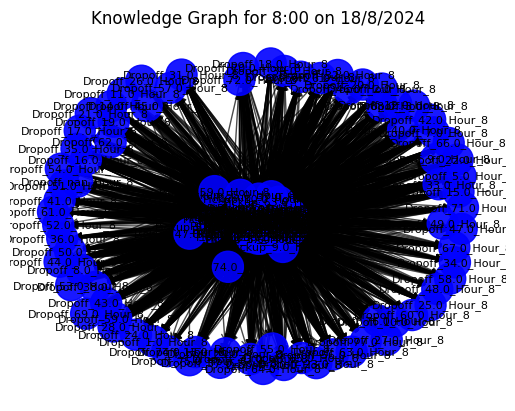

In [42]:
# Example: Visualize graph for 8 AM on 2024-08-18
hour = 8
day = 18
month = 8
year = 2024

filtered_graph = filter_graph_by_time_step(graph, hour, day, month, year)
visualize_knowledge_graph(filtered_graph, title=f"Knowledge Graph for {hour}:00 on {day}/{month}/{year}")


In [44]:
from pyvis.network import Network

def visualize_knowledge_graph_interactive(graph, title="Knowledge Graph", output_file="knowledge_graph.html"):
    """Visualize the knowledge graph interactively using pyvis."""
    net = Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black", notebook=True)

    # Add nodes to the pyvis graph
    for node, data in graph.nodes(data=True):
        node_color = "gray"  # Default color
        if "Pickup" in node:
            node_color = "blue"
        elif "Dropoff" in node:
            node_color = "red"
        elif "Fare" in node:
            node_color = "green"
        elif "Shared" in node:
            node_color = "orange"
        elif "Pooled" in node:
            node_color = "purple"
        elif "Weekday" in node or "Weekend" in node or "Holiday" in node:
            node_color = "yellow"

        net.add_node(
            node,
            label=node,
            title=f"Type: {data.get('type', 'Unknown')}, Value: {data.get('value', '')}",
            color=node_color,
            shape="dot",
            size=10,
        )

    # Add edges to the pyvis graph
    for u, v, data in graph.edges(data=True):
        net.add_edge(u, v, title=data.get("relationship", "Relation"), weight=data.get("weight", 1))

    # Generate and show the interactive visualization
    net.set_options("""
    var options = {
      "nodes": {
        "borderWidth": 2,
        "size": 15,
        "font": {
          "size": 10
        },
        "shapeProperties": {
          "useBorderWithImage": true
        }
      },
      "edges": {
        "color": {
          "inherit": true
        },
        "smooth": {
          "type": "dynamic"
        }
      },
      "physics": {
        "enabled": true,
        "barnesHut": {
          "gravitationalConstant": -20000,
          "centralGravity": 0.3,
          "springLength": 95,
          "springConstant": 0.04
        }
      }
    }
    """)
    net.show(output_file)
    print(f"Knowledge graph saved to {output_file}")


In [46]:
# Filter the graph for a specific time step
hour = 8
day = 18
month = 8
year = 2024

filtered_graph = filter_graph_by_time_step(graph, hour, day, month, year)

# Visualize the filtered graph interactively
visualize_knowledge_graph_interactive(
    filtered_graph,
    title=f"Knowledge Graph for {hour}:00 on {day}/{month}/{year}",
    output_file="knowledge_graph_timestep.html",
)


knowledge_graph_timestep.html
Knowledge graph saved to knowledge_graph_timestep.html


In [9]:
community_areas = pd.read_csv("/scratch/umni5/a/shives/Knowledge_graph/CommAreas_20241209.csv")

In [10]:
community_areas["geometry"] = community_areas["the_geom"].apply(loads)

In [11]:
community_areas_gdf = gpd.GeoDataFrame(community_areas, geometry="geometry", crs="EPSG:4326")

In [12]:
poi_df = pd.read_csv("poi_filter.csv")

In [14]:
poi_df["geometry"] = poi_df.apply(lambda row: Point(row["lng"], row["lat"]), axis=1)
poi_gdf = gpd.GeoDataFrame(poi_df, geometry="geometry", crs="EPSG:4326")


In [15]:
result = gpd.sjoin(poi_gdf, community_areas_gdf, how="left", predicate="within")

In [17]:
result

,Unnamed: 0,name,poi_id,osm_way_id,building,amenity,leisure,area,area_ft2,lat,...,the_geom,PERIMETER,AREA,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN
0,75710,Olive Garden,299,2.889874e+07,yes,restaurant,NaN,929.4,10003.7,42.011047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75711,Bison Prarie Grill,390,3.146721e+07,yes,fast_food,NaN,365.6,3935.3,41.832149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,75712,McDonald's,727,4.078274e+07,yes,fast_food,NaN,650.4,7001.3,41.933583,...,MULTIPOLYGON (((-87.64102430213292 41.95480280...,0.0,0.0,0.0,0.0,6.0,LAKE VIEW,6.0,8.721480e+07,51973.096868
3,75713,Palace Grill Restaurant,742,4.078542e+07,yes,restaurant,NaN,231.7,2494.3,41.881692,...,MULTIPOLYGON (((-87.6375883858287 41.886234136...,0.0,0.0,0.0,0.0,28.0,NEAR WEST SIDE,28.0,1.584925e+08,53003.592941
4,75714,McDonald's,763,4.122950e+07,yes,fast_food,NaN,491.4,5289.6,41.924767,...,MULTIPOLYGON (((-87.63181810269614 41.93258180...,0.0,0.0,0.0,0.0,7.0,LINCOLN PARK,7.0,8.831640e+07,49478.427771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75593,1573,NaN,893560,1.092464e+09,static_caravan,NaN,NaN,82.1,883.9,41.782164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75594,1574,California Station,894017,NaN,train_station,NaN,NaN,179.8,1935.1,41.922055,...,MULTIPOLYGON (((-87.68284015972066 41.93222871...,0.0,0.0,0.0,0.0,22.0,LOGAN SQUARE,22.0,1.000576e+08,49213.421749
75595,1575,O'Hare Bus/Shuttle Center,894294,NaN,yes,bus_station,NaN,2162.2,23273.3,41.977942,...,MULTIPOLYGON (((-87.83658087874365 41.98639611...,0.0,0.0,0.0,0.0,76.0,OHARE,76.0,3.718356e+08,173625.984660
75596,1576,95th/Dan Ryan,894324,NaN,train_station,NaN,NaN,13157.2,141622.8,41.721818,...,MULTIPOLYGON (((-87.60449169338277 41.72254809...,0.0,0.0,0.0,0.0,49.0,ROSELAND,49.0,1.343137e+08,56632.795429


In [18]:
result_with_community_areas = result[["name", "poi_id", 'cate',"lat", "lng", "COMMUNITY",'AREA_NUMBE']]
print(result_with_community_areas)

                            name  poi_id            cate        lat  \
0                   Olive Garden     299        catering  42.011047   
1             Bison Prarie Grill     390        catering  41.832149   
2                     McDonald's     727        catering  41.933583   
3        Palace Grill Restaurant     742        catering  41.881692   
4                     McDonald's     763        catering  41.924767   
...                          ...     ...             ...        ...   
75593                        NaN  893560  transportation  41.782164   
75594         California Station  894017  transportation  41.922055   
75595  O'Hare Bus/Shuttle Center  894294  transportation  41.977942   
75596              95th/Dan Ryan  894324  transportation  41.721818   
75597     Clinton Street Station  894359  transportation  41.885719   

             lng       COMMUNITY  AREA_NUMBE  
0     -87.712001             NaN         NaN  
1     -87.837798             NaN         NaN  
2     

In [19]:
result_with_community_areas = result_with_community_areas.dropna(subset=["COMMUNITY"])


In [20]:
result_with_community_areas.to_csv('POIs.csv', index=False)